In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [2]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


# Multiple features

In [40]:
def generate_synthetic_fico_data(n=5000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)/10 # Divide by 10 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)*10
    
    return df

def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()


In [41]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [42]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,74.967142,76.585719,76.9,81.4,49.739132,738.631284,0.999859,1
1,68.617357,78.665854,48.0,62.3,66.338543,676.796854,0.935817,1
2,76.476885,67.594270,56.4,61.9,36.255519,653.207428,0.579505,0
3,85.230299,68.733246,59.4,75.9,56.607518,726.113302,0.999505,1
4,67.658466,56.717203,54.6,83.1,66.026860,637.983101,0.231175,0
5,67.658630,73.988014,72.3,80.1,72.054758,719.374005,0.999030,1
6,85.792128,79.777169,35.8,77.9,63.647253,734.851207,0.999794,1
7,75.674347,69.250936,75.7,66.4,76.769182,729.332205,0.999641,1
8,65.305256,78.221344,31.0,82.2,60.015412,651.947840,0.548543,1
9,75.425600,78.472212,64.6,65.1,77.105293,738.511532,0.999857,1


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# Get the predicted probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Find the optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
optimal_idx = np.argmax(tpr - 0.2*fpr)
optimal_threshold_probability = thresholds[optimal_idx]

print(f"Optimal Probability Threshold: {optimal_threshold_probability}")

Optimal Probability Threshold: 0.2542530854739538


In [44]:
# Fit the model with all features
model_full = LogisticRegression()
model_full.fit(X_train, y_train)

# Get the feature names and their corresponding coefficients from the model
feature_names = X.columns
coefficients = model_full.coef_[0]

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.3257
Amounts Owed: 0.2922
Length of Credit History: 0.1461
Credit Mix: 0.0840
New Credit: 0.0906


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


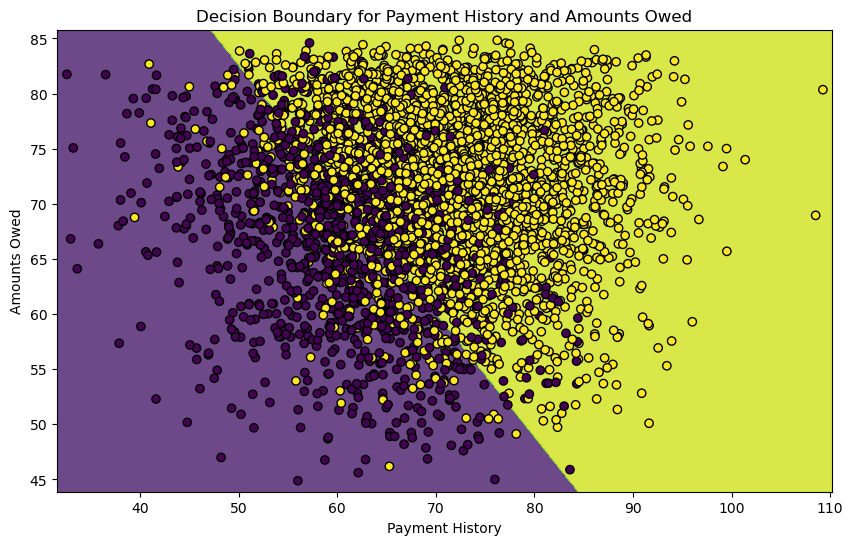

In [45]:
# Reduce X to two dimensions (for visualization purposes)
X_plot = fico_df[['Payment History', 'Amounts Owed']]
X_train_plot, X_test_plot, _, _ = train_test_split(X_plot, y, test_size=0.2, random_state=42)

# Train a new logistic regression model on these two features
model_plot = LogisticRegression()
model_plot.fit(X_train_plot, y_train)

# Create a mesh grid spanning the range of Payment History and Amounts Owed values
x_min, x_max = X_train_plot.iloc[:, 0].min() - 1, X_train_plot.iloc[:, 0].max() + 1
y_min, y_max = X_train_plot.iloc[:, 1].min() - 1, X_train_plot.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict each point on the mesh grid
Z = model_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_plot.iloc[:, 0], X_train_plot.iloc[:, 1], c=y_train, edgecolors='k')
plt.xlabel('Payment History')
plt.ylabel('Amounts Owed')
plt.title('Decision Boundary for Payment History and Amounts Owed')
plt.show()

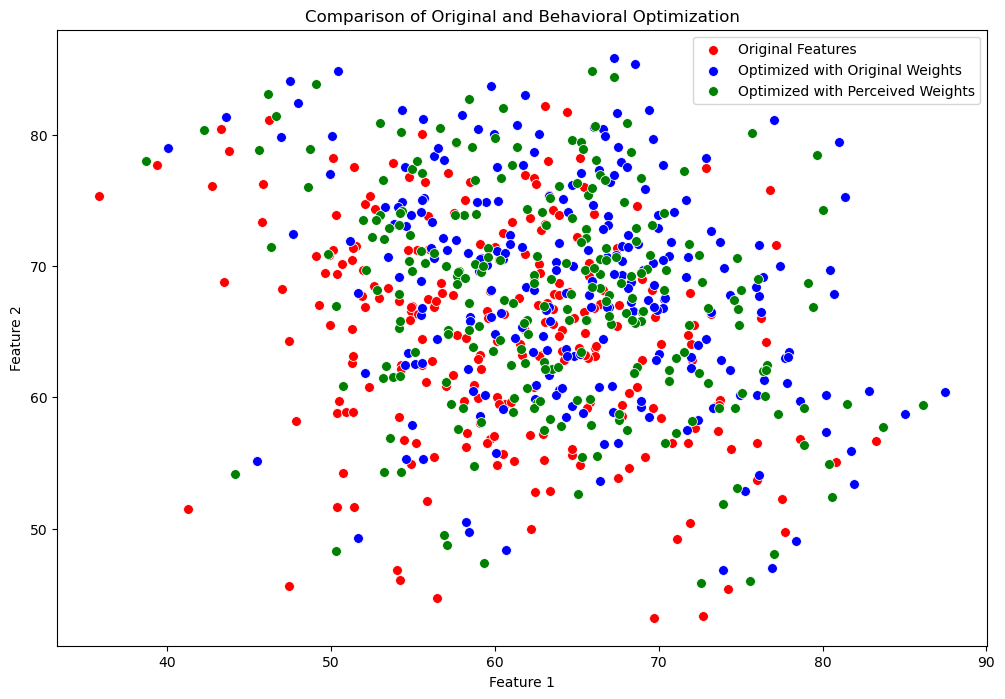

Success rate of gaming the system (Non-behavioral): 43.22%
Success rate of gaming the system (Behavioral): 37.71%


In [46]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

# Optimization function to maximize FICO score given the budget
def optimize_features(current_features, budget, weights):
    # Number of features
    n_features = len(current_features)
    
    # Define the optimization variables (amount to increase each feature)
    x = cp.Variable(n_features, nonneg=True)
    
    # Objective function: maximize the weighted sum of features (proxy for FICO score)
    objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p(x))))
    
    # Constraints
    constraints = [cp.sum(x) == budget]  # Total budget constraint
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Return the new feature values if the problem is feasible
    if problem.status == cp.OPTIMAL:
        return x.value + current_features
    else:
        return current_features

# Predict initial labels
initial_predictions = model.predict(X_test)

# Find users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

gamma = 0.5  # Example gamma value
budget = 10  # Define some budget
model_weights = model.coef_[0]  # Actual model weights
perceived_weights = behavioral(model_weights, gamma)

# Predict initial labels
initial_predictions = model.predict(X_test)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=model_weights)

# Optimization using perceived weights
optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=perceived_weights)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_to_optimize.iloc[:, 0], y=X_to_optimize.iloc[:, 1], color='red', label='Original Features', s=50)
sns.scatterplot(x=optimized_features_original.iloc[:, 0], y=optimized_features_original.iloc[:, 1], color='blue', label='Optimized with Original Weights', s=50)
sns.scatterplot(x=optimized_features_perceived.iloc[:, 0], y=optimized_features_perceived.iloc[:, 1], color='green', label='Optimized with Perceived Weights', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Comparison of Original and Behavioral Optimization')
plt.legend()
plt.show()


# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_perceived = model.predict(optimized_features_perceived)

# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Success rate of gaming the system (Non-behavioral): {success_rate_original:.2%}")

success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
print(f"Success rate of gaming the system (Behavioral): {success_rate_perceived:.2%}")




# # Prepare data for plotting
# plot_data = pd.DataFrame({
#     'Original Feature 1': X_to_optimize.iloc[:, 0],
#     'Original Feature 2': X_to_optimize.iloc[:, 1],
#     'Optimized Feature 1': optimized_features.iloc[:, 0],
#     'Optimized Feature 2': optimized_features.iloc[:, 1],
#     'Outcome': ['Success' if x == 1 else 'Fail' for x in optimized_predictions]
# })

# # Visualizing the results using seaborn
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='Original Feature 1', y='Original Feature 2', data=plot_data, hue='Outcome', style='Outcome', s=100, palette={'Fail': 'red', 'Success': 'green'}, markers={'Fail': 'X', 'Success': 'o'}, alpha=0.5)
# sns.scatterplot(x='Optimized Feature 1', y='Optimized Feature 2', data=plot_data, hue='Outcome', style='Outcome', s=50, palette={'Fail': 'red', 'Success': 'blue'}, markers={'Fail': 'X', 'Success': 'o'})
# plt.title('Gaming the Algorithm: Original vs Optimized Features')
# plt.legend(title='Gaming Outcome', loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

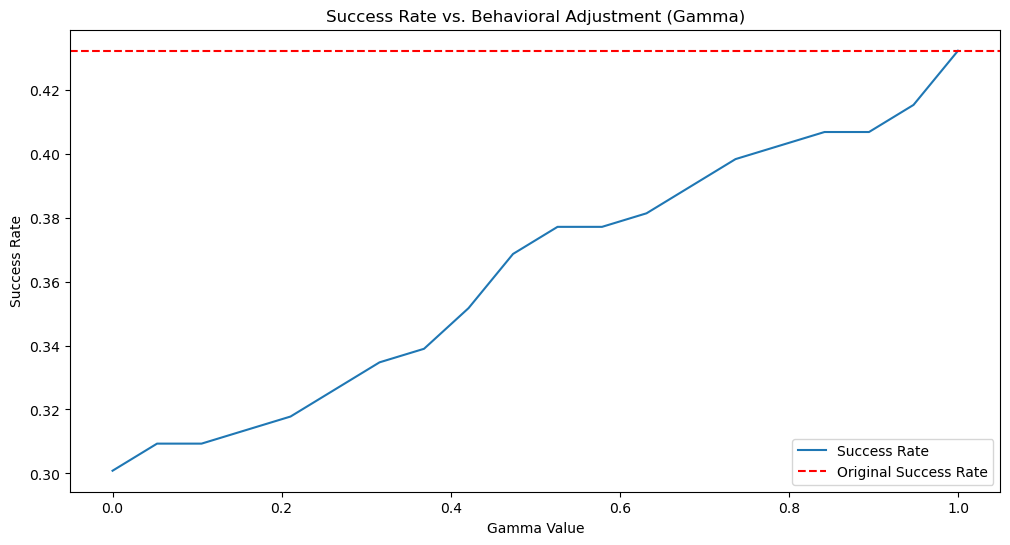

In [48]:
# plot success rate for different gamma values
gammas = np.linspace(0, 1, 20)
success_rates = []
iterations = 100

for gamma in gammas:
    success_rate = 0
    for _ in range(iterations):
        # Select users who are true negatives and predicted negatives
        mask = (y_test == 0) & (initial_predictions == 0)
        X_to_optimize = X_test[mask].copy()

        # Optimization using perceived weights
        optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, budget=budget, weights=behavioral(model_weights, gamma))

        # Predict with the optimized features
        optimized_predictions_perceived = model.predict(optimized_features_perceived)

        # Calculate success rate
        success_rate += np.mean(optimized_predictions_perceived == 1)
    
    success_rates.append(success_rate / iterations)

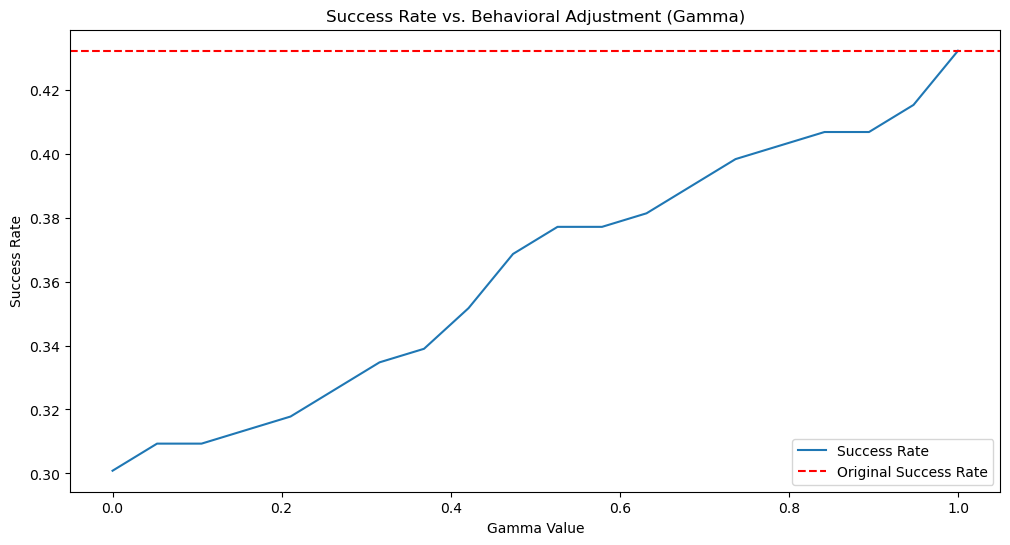

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(gammas, success_rates, label='Success Rate')
# plot original success rate
plt.axhline(y=success_rate_original, color='r', linestyle='--', label='Original Success Rate')
plt.xlabel('Gamma Value')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Behavioral Adjustment (Gamma)')
plt.legend()
plt.savefig('success_rates.png')
plt.show()